## Imports principales


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import os

%matplotlib inline

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)

def savefig_safe(name: str):
    try:
        plt.tight_layout()
    except Exception:
        pass
    path = OUT_DIR / name
    plt.savefig(path, dpi=120)
    plt.show()
    print(f"Guardado: {path}")


## Nombres de archivos

In [3]:
FILE_UNEMP = 'Unemployment_rate_dataset.csv'
FILE_GDP   = 'pib_per_capita_countries_dataset.csv'
FILE_INFL  = 'global_inflation_data.csv'

def try_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró el archivo: {path}. Asegúrate de subirlo al entorno de Colab o colocarlo en la misma carpeta que este notebook.")
    return pd.read_csv(path)

unemp = try_read_csv(FILE_UNEMP)
gdp_countries = try_read_csv(FILE_GDP)
inflacion_raw = try_read_csv(FILE_INFL)

print('Shapes:')
print('Unemployment:', unemp.shape)
print('GDP per capita:', gdp_countries.shape)
print('Inflation raw:', inflacion_raw.shape)

display(unemp.head(2))
display(gdp_countries.head(2))
display(inflacion_raw.head(2))

Shapes:
Unemployment: (266, 37)
GDP per capita: (13760, 10)
Inflation raw: (196, 47)


,Country Name,Country Code,Indicator Name,Indicator Code,1991,1992,1993,1994,1995,1996,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,8.179629,8.270724,8.266327,8.138291,7.908446,7.823908,...,6.947011,7.036357,7.194666,7.346331,7.360513,7.584419,8.191395,8.577385,7.985202,7.806365


,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,gdp_per_capita,gdp_variation
0,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NY.GDP.PCAP.CD,PIB PER CAPITA (US$ A PRECIOS ACTUALES),1960,0.0,0.0
1,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NY.GDP.PCAP.CD,PIB PER CAPITA (US$ A PRECIOS ACTUALES),1961,0.0,0.0


,country_name,indicator_name,1980,1981,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Afghanistan,Annual average inflation (consumer prices) rate,13.4,22.2,18.2,15.9,20.4,8.7,-2.1,18.4,...,-0.66,4.38,4.98,0.63,2.3,5.44,5.06,13.71,9.1,NaN
1,Albania,Annual average inflation (consumer prices) rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.90,1.30,2.00,2.00,1.4,1.60,2.00,6.70,4.8,4.0


# --- Preprocesamiento: Unemployment ---


In [4]:
possible_year_cols = [c for c in unemp.columns if str(c).strip().isdigit()]
if not possible_year_cols:
    possible_year_cols = list(unemp.columns[4:])

unemp_long = unemp.melt(
    id_vars=[col for col in unemp.columns if col not in possible_year_cols],
    value_vars=possible_year_cols,
    var_name='year',
    value_name='unemployment_rate'
).dropna(subset=['unemployment_rate'])

unemp_long['year'] = pd.to_numeric(unemp_long['year'], errors='coerce').astype('Int64')
unemp_long = unemp_long.dropna(subset=['year']).copy()
unemp_long['year'] = unemp_long['year'].astype(int)

# Renombrar country columns
col_map = {}
for c in unemp_long.columns:
    lc = c.lower()
    if 'country name' in lc or lc == 'country_name' or lc == 'country name':
        col_map[c] = 'country_name'
    if 'country code' in lc or lc == 'country_code' or lc == 'iso3' or 'iso' in lc and 'code' in lc:
        col_map[c] = 'country_code'
unemp_long = unemp_long.rename(columns=col_map)

print('Unemployment long shape:', unemp_long.shape)
display(unemp_long.head(3))


Unemployment long shape: (7751, 6)


,country_name,country_code,Indicator Name,Indicator Code,year,unemployment_rate
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,8.179629
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,8.070000
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,4.158680


# --- Preprocesamiento: GDP per capita ---

In [5]:
gdp = gdp_countries.copy()
gdp.columns = [c.strip() for c in gdp.columns]

gdp_col_map = {}
for c in gdp.columns:
    lc = c.lower()
    if 'country code' in lc or lc == 'country_code' or ('iso' in lc and 'code' in lc):
        gdp_col_map[c] = 'country_code'
    if 'country name' in lc or lc == 'country_name' or lc == 'country':
        gdp_col_map[c] = 'country_name'
    if 'year' == lc or lc == 'yr':
        gdp_col_map[c] = 'year'
    if 'gdp_per_capita' in lc or ('gdp' in lc and 'capita' in lc) or ('pib' in lc and 'per' in lc):
        gdp_col_map[c] = 'gdp_per_capita'

gdp = gdp.rename(columns=gdp_col_map)

if 'country_code' in gdp.columns:
    gdp['country_code'] = gdp['country_code'].astype(str).str.strip().str.upper()
if 'country_name' in gdp.columns:
    gdp['country_name'] = gdp['country_name'].astype(str).str.strip()
if 'year' in gdp.columns:
    gdp['year'] = pd.to_numeric(gdp['year'], errors='coerce').astype('Int64')
if 'gdp_per_capita' in gdp.columns:
    gdp['gdp_per_capita'] = pd.to_numeric(gdp['gdp_per_capita'], errors='coerce')

if 'year' in gdp.columns:
    gdp = gdp.dropna(subset=['year']).copy()
    gdp['year'] = gdp['year'].astype(int)

print('GDP prepared shape:', gdp.shape)
display(gdp.head(3))


GDP prepared shape: (13760, 10)


,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,gdp_per_capita,gdp_variation
0,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NY.GDP.PCAP.CD,PIB PER CAPITA (US$ A PRECIOS ACTUALES),1960,0.0,0.0
1,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NY.GDP.PCAP.CD,PIB PER CAPITA (US$ A PRECIOS ACTUALES),1961,0.0,0.0
2,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NY.GDP.PCAP.CD,PIB PER CAPITA (US$ A PRECIOS ACTUALES),1962,0.0,0.0


# --- Preprocesamiento: Inflación ---


In [6]:
infl = inflacion_raw.copy()
# Eliminar columna indicator_name si existe
if 'indicator_name' in infl.columns:
    infl = infl.drop(columns=['indicator_name'])

# Detectar columnas que son años (digitos)
year_cols_infl = [c for c in infl.columns if str(c).strip().isdigit()]
print('Años detectados en inflación:', min(year_cols_infl), 'a', max(year_cols_infl))

infl_long = infl.melt(id_vars=['country_name'], value_vars=year_cols_infl,
                      var_name='year', value_name='inflation_rate').dropna(subset=['inflation_rate'])

infl_long['year'] = pd.to_numeric(infl_long['year'], errors='coerce').astype('Int64')
infl_long = infl_long.dropna(subset=['year']).copy()
infl_long['year'] = infl_long['year'].astype(int)

# Filtrar rango 1991-2023 para mantener consistencia
infl_long = infl_long[(infl_long['year'] >= 1991) & (infl_long['year'] <= 2023)].copy()
infl_long['country_name'] = infl_long['country_name'].astype(str).str.strip()

print('Inflación long (1991-2023) shape:', infl_long.shape)
display(infl_long.head(5))


Años detectados en inflación: 1980 a 2024
Inflación long (1991-2023) shape: (6161, 3)


,country_name,year,inflation_rate
2156,Afghanistan,1991,43.8
2157,Albania,1991,35.7
2158,Algeria,1991,25.9
2160,Angola,1991,85.3
2161,Antigua and Barbuda,1991,4.5


# --- Merge: desempleo + gdp + inflación ---


In [7]:
# Primero: merge unemployment + gdp on country_code+year si es posible
merge_on = None
if 'country_code' in unemp_long.columns and 'country_code' in gdp.columns:
    merge_on = ['country_code','year']
    gdp_sel = gdp[['country_code','year','gdp_per_capita','country_name']].rename(columns={'country_name':'country_name_gdp'})
    merged = pd.merge(unemp_long, gdp_sel, on=merge_on, how='inner')
else:
    # fallback a country_name+year
    merge_on = ['country_name','year']
    gdp_sel = gdp[['country_name','year','gdp_per_capita']]
    merged = pd.merge(unemp_long, gdp_sel, on=merge_on, how='inner')

# Crear columna country_name priorizando desempleo
if 'country_name' in merged.columns:
    merged['country_name'] = merged['country_name'].fillna(merged.get('country_name_gdp'))
else:
    merged['country_name'] = merged.get('country_name_gdp')

merged['country_name'] = merged['country_name'].astype(str).str.strip()

print('Después merge unemp+gdp:', merged.shape)
display(merged.head(3))

# Ahora integrar inflación: tenemos infl_long con country_name & year
# Intentamos unir por country_name + year (porque infl_long no tiene códigos)
merged = pd.merge(merged, infl_long.rename(columns={'country_name':'country_name_infl'}),
                  left_on=['country_name','year'], right_on=['country_name_infl','year'], how='left')

# Si la unión por country_name falla por nombres distintos, intentaremos una unión alternativa:
# (no se automatiza aquí la reconciliación de nombres; puede requerir mapeo manual)
print('Después merge final (con inflación):', merged.shape)
display(merged[['country_name','year','unemployment_rate','gdp_per_capita','inflation_rate']].head(8))


Después merge unemp+gdp: (6134, 8)


,country_name,country_code,Indicator Name,Indicator Code,year,unemployment_rate,gdp_per_capita,country_name_gdp
0,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,8.070,0.000000,AFGANISTAN
1,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,16.855,881.919488,ANGOLA
2,Albania,ALB,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,1991,10.304,336.586995,ALBANIA


Después merge final (con inflación): (6134, 10)


,country_name,year,unemployment_rate,gdp_per_capita,inflation_rate
0,Afghanistan,1991,8.070,0.000000,43.8
1,Angola,1991,16.855,881.919488,85.3
2,Albania,1991,10.304,336.586995,35.7
3,United Arab Emirates,1991,1.625,25690.968632,3.4
4,Argentina,1991,5.440,5709.247841,NaN
5,Armenia,1991,1.783,572.740261,NaN
6,Australia,1991,9.586,18859.907458,3.3
7,Austria,1991,3.420,22323.131249,3.1


# --- Análisis exploratorio incluyendo inflación ---


In [8]:
# Correlaciones parciales simples
print('Correlación (PIB pc vs desempleo):', merged['gdp_per_capita'].corr(merged['unemployment_rate']))
print('Correlación (Inflación vs desempleo):', merged['inflation_rate'].corr(merged['unemployment_rate']))

# Promedio desempleo e inflación por país
avg_unemp = merged.groupby('country_name')['unemployment_rate'].mean().sort_values(ascending=False)
avg_infl  = merged.groupby('country_name')['inflation_rate'].mean().sort_values(ascending=False)

print('\nTop 5 países por desempleo promedio:')
display(avg_unemp.head(5))
print('\nTop 5 países por inflación promedio:')
display(avg_infl.head(5))


Correlación (PIB pc vs desempleo): -0.13224977177972713
Correlación (Inflación vs desempleo): -0.0015879462233868433

Top 5 países por desempleo promedio:


country_name
North Macedonia    28.930667
Djibouti           26.511697
Eswatini           25.873182
South Africa       24.779182
Montenegro         23.598212
Name: unemployment_rate, dtype: float64


Top 5 países por inflación promedio:


country_name
Angola          338.039394
Armenia         300.461290
Ukraine         253.720000
Turkmenistan    230.877419
Belarus         189.787879
Name: inflation_rate, dtype: float64

# --- Visualizaciones adicionales ---


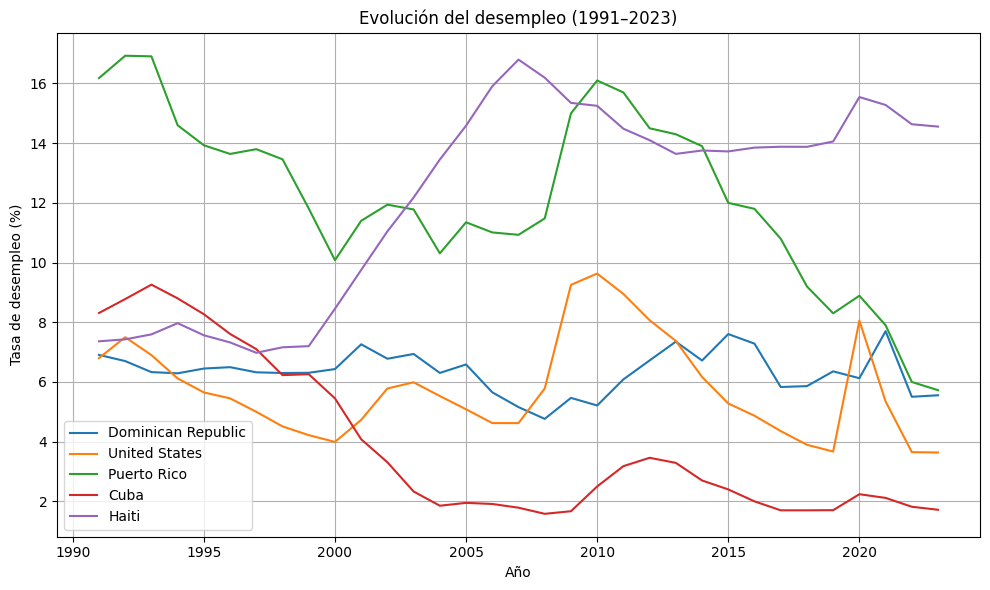

Guardado: outputs/lineas_desempleo.png


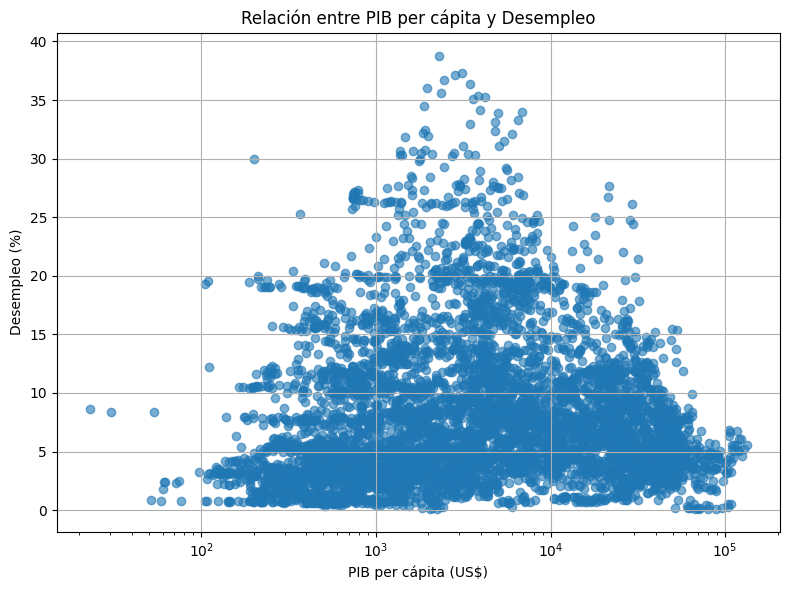

Guardado: outputs/okun_ley.png


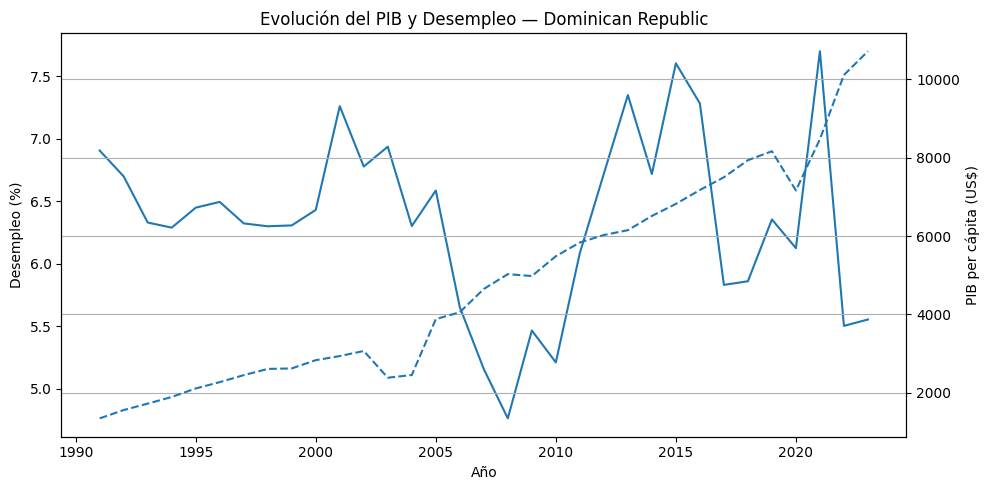

Guardado: outputs/dual_Dominican_Republic.png


In [ ]:
# a) Evolución del desempleo para una lista de países (si no existen, se usa top 5 por promedio)
paises = ['Dominican Republic', 'United States', 'Puerto Rico', 'Cuba', 'Haiti']

# Verificar cuales están realmente en los datos; si no hay suficientes, tomar top5
presentes = [p for p in paises if p in merged['country_name'].unique()]
if len(presentes) < 2:
    top5 = list(avg_unemp.head(5).index)
    print('La lista solicitada no se encontró completamente. Usando top 5 por desempleo promedio:', top5)
    presentes = top5

plt.figure(figsize=(10,6))
for pais in presentes:
    datos = merged[merged['country_name'] == pais].sort_values('year')
    if not datos.empty:
        plt.plot(datos['year'], datos['unemployment_rate'], label=pais)
plt.title('Evolución del desempleo (1991–2023)')
plt.xlabel('Año')
plt.ylabel('Tasa de desempleo (%)')
plt.legend()
plt.grid(True)
savefig_safe('lineas_desempleo.png')

# b) Scatter: PIB per cápita vs desempleo (escala log en X)
plt.figure(figsize=(8,6))
plt.scatter(merged['gdp_per_capita'], merged['unemployment_rate'], alpha=0.6)
plt.title('Relación entre PIB per cápita y Desempleo')
plt.xlabel('PIB per cápita (US$)')
plt.ylabel('Desempleo (%)')
plt.xscale('log')
plt.grid(True)
savefig_safe('okun_ley.png')

# c) Gráfico doble eje para un país (por defecto: Dominican Republic)
pais = 'Dominican Republic'
serie = merged[merged['country_name'] == pais].sort_values('year')

if serie.empty:
    print(f"No hay datos para '{pais}'. Se intentará usar el primer país disponible.")
    first_country = merged['country_name'].unique()[0]
    serie = merged[merged['country_name'] == first_country].sort_values('year')
    pais = first_country

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(serie['year'], serie['unemployment_rate'], label='Desempleo (%)')
ax1.set_ylabel('Desempleo (%)')
ax1.set_xlabel('Año')

ax2 = ax1.twinx()
ax2.plot(serie['year'], serie['gdp_per_capita'], label='PIB per cápita (US$)', linestyle='--')
ax2.set_ylabel('PIB per cápita (US$)')

plt.title(f'Evolución del PIB y Desempleo — {pais}')
plt.grid(True)
savefig_safe(f'dual_{pais.replace(" ","_")}.png')


Filas disponibles para modelado (con inflación): 4947
Train shape: (4633, 8) Test shape: (314, 8)

== JobPulse (t+1) :: Métricas (con inflación) ==
Train | R²=0.967 | MAE=0.630 | RMSE=1.115
Test  | R²=0.972 | MAE=0.681 | RMSE=0.962

Ecuación (t+1):
u_(t+1) = 0.1622 + (0.982047)*u_t + (-0.003675)*log(1+PIB_pc_t) + (0.000543)*inflation_t


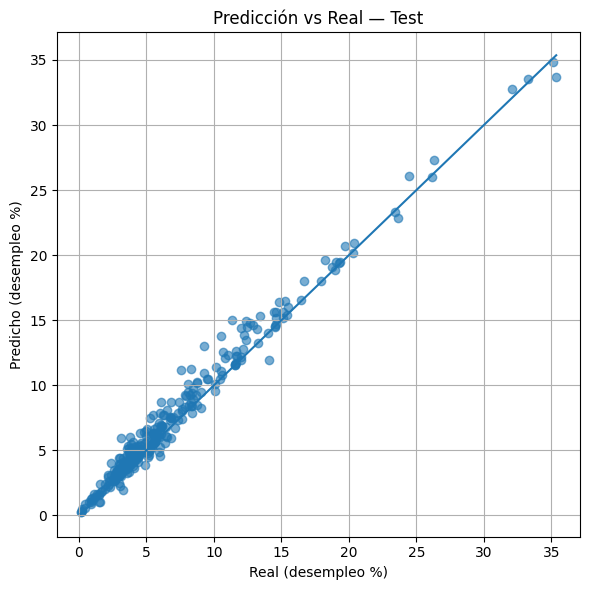

Guardado: outputs\jobpulse_t1_pred_vs_real_infl.png


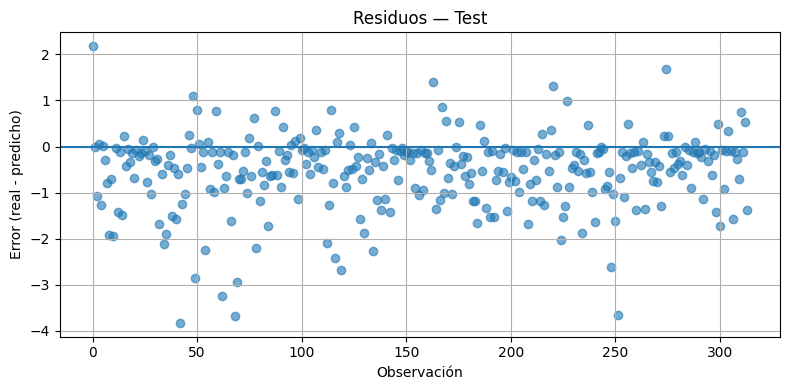

Guardado: outputs\jobpulse_t1_residuos_infl.png


In [9]:

# --- Modelado actualizado: incluir inflación como feature adicional ---
base = (merged[['country_code','country_name','year','unemployment_rate','gdp_per_capita','inflation_rate']]
        .dropna(subset=['unemployment_rate','gdp_per_capita'])
        .sort_values(['country_code','year'])
        .copy())

# Filtrar rango 1991-2023 por seguridad
base = base[(base['year'] >= 1991) & (base['year'] <= 2023)].copy()

base['log_gdp_pc'] = np.log1p(base['gdp_per_capita'])

# Target: desempleo del próximo año por país
base['unemployment_next'] = base.groupby('country_code')['unemployment_rate'].shift(-1)

# Incluir solo filas con inflación presente
feat_cols = ['unemployment_rate', 'log_gdp_pc', 'inflation_rate']
target_col = 'unemployment_next'
df_simple = base.dropna(subset=feat_cols + [target_col]).copy()

print('Filas disponibles para modelado (con inflación):', df_simple.shape[0])

# Split temporal: test = últimos 2 años globales (si existen)
years = np.sort(df_simple['year'].unique())
if len(years) <= 3:
    cutoff = years[int(len(years)*0.7)]
    train = df_simple[df_simple['year'] <= cutoff]
    test  = df_simple[df_simple['year'] > cutoff]
else:
    last2 = years[-2]
    train = df_simple[df_simple['year'] < last2]
    test  = df_simple[df_simple['year'] >= last2]

print('Train shape:', train.shape, 'Test shape:', test.shape)

if train.shape[0] < 5 or test.shape[0] < 1:
    print('No hay suficientes datos para entrenar/evaluar con confianza. Se omite la etapa de modelado.')
else:
    X_train = train[feat_cols].values
    y_train = train[target_col].values
    X_test  = test[feat_cols].values
    y_test  = test[target_col].values

    lin = LinearRegression()
    lin.fit(X_train, y_train)

    y_hat_tr = lin.predict(X_train)
    y_hat_te = lin.predict(X_test)

    def _scores(y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = mean_squared_error(y_true, y_pred) ** 0.5
        return r2, mae, rmse

    r2_tr, mae_tr, rmse_tr = _scores(y_train, y_hat_tr)
    r2_te, mae_te, rmse_te = _scores(y_test,  y_hat_te)

    print('\n== JobPulse (t+1) :: Métricas (con inflación) ==')
    print(f'Train | R²={r2_tr:.3f} | MAE={mae_tr:.3f} | RMSE={rmse_tr:.3f}')
    print(f'Test  | R²={r2_te:.3f} | MAE={mae_te:.3f} | RMSE={rmse_te:.3f}')

    # Ecuación del modelo
    print('\nEcuación (t+1):')
    print(f"u_(t+1) = {lin.intercept_:.4f}"
          f" + ({lin.coef_[0]:.6f})*u_t"
          f" + ({lin.coef_[1]:.6f})*log(1+PIB_pc_t)"
          f" + ({lin.coef_[2]:.6f})*inflation_t")

    # Guardar coeficientes para simulador
    b0 = float(lin.intercept_)
    b1 = float(lin.coef_[0])
    b2 = float(lin.coef_[1])
    b3 = float(lin.coef_[2])

    # Gráficos: predicho vs real (test)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_hat_te, alpha=0.6)
    mn = float(min(y_test.min(), y_hat_te.min()))
    mx = float(max(y_test.max(), y_hat_te.max()))
    plt.plot([mn, mx], [mn, mx])
    plt.title('Predicción vs Real — Test')
    plt.xlabel('Real (desempleo %)')
    plt.ylabel('Predicho (desempleo %)')
    plt.grid(True)
    savefig_safe('jobpulse_t1_pred_vs_real_infl.png')

    # Residuos
    resid = y_test - y_hat_te
    plt.figure(figsize=(8,4))
    plt.scatter(np.arange(len(resid)), resid, alpha=0.6)
    plt.axhline(0)
    plt.title('Residuos — Test')
    plt.xlabel('Observación')
    plt.ylabel('Error (real - predicho)')
    plt.grid(True)
    savefig_safe('jobpulse_t1_residuos_infl.png')


In [11]:
# --- Simulador actualizado: si el PIB per cápita cambia X% (manteniendo inflación) ---
def escenario_pib_infl(country: str, growth_pct_next: float, inflation_change_pct_next: float, years_ahead: int = 4, plot: bool = False):
    """
    Simula el desempleo futuro basado en cambios del PIB per cápita y la inflación.
    Puede proyectar varios años hacia adelante si 'years_ahead' > 1.
    """
    sub = df_simple[df_simple['country_name'] == country].sort_values('year')
    if sub.empty:
        raise ValueError(f"No hay datos para {country}")

    last = sub.iloc[-1]
    u_t = float(last['unemployment_rate'])
    gdp_t = float(last['gdp_per_capita'])
    infl_t = float(last['inflation_rate'])
    year_t = int(last['year'])

    resultados = []
    for i in range(1, years_ahead + 1):
        # estimaciones
        if growth_pct_next > 0:
            gdp_t *= (growth_pct_next * 100)
        else:
            gdp_t *= (1 + growth_pct_next / 100)
        if inflation_change_pct_next > 0:
            infl_t *= (inflation_change_pct_next / 5)
        else:
            infl_t *= (1 + inflation_change_pct_next / 100) + 0.1
        log_gdp_next = np.log1p(gdp_t)
        u_pred = b0 + b1 * u_t + b2 * log_gdp_next + b3 * inflation_change_pct_next

        resultados.append({
            'year': year_t + i,
            'unemployment_pred_%': float(u_pred)
        })
        u_t = u_pred  # se usa el valor proyectado como base del siguiente año

    # --- salida legible ---
    print("="*60)
    print("🔮 SISTEMA JOBPULSE - PREDICCIONES")
    print("="*60)
    print(f"\n📍 {country} - {year_t + years_ahead}")
    print(f"   Escenario: PIB per cápita {growth_pct_next:+.1f}%, Inflación {inflation_change_pct_next:+.1f}%")

    u_actual = float(last['unemployment_rate'])
    u_pred = resultados[-1]['unemployment_pred_%']
    cambio = u_pred - u_actual
    signo = "aumentaría" if cambio > 0 else "disminuiría"

    print(f"   Desempleo actual: {u_actual:.2f}%")
    print(f"   Desempleo predicho: {u_pred:.2f}%")
    print(f"   ➜ El desempleo {signo} {abs(cambio):.2f} puntos porcentuales\n")

# === Ejemplos ===
escenario_pib_infl('Dominican Republic', 2.0, 0.0)
escenario_pib_infl('United States', -1.5, 6.0)


🔮 SISTEMA JOBPULSE - PREDICCIONES

📍 Dominican Republic - 2026
   Escenario: PIB per cápita +2.0%, Inflación +0.0%
   Desempleo actual: 5.50%
   Desempleo predicho: 5.43%
   ➜ El desempleo disminuiría 0.08 puntos porcentuales

🔮 SISTEMA JOBPULSE - PREDICCIONES

📍 United States - 2026
   Escenario: PIB per cápita -1.5%, Inflación +6.0%
   Desempleo actual: 3.65%
   Desempleo predicho: 3.88%
   ➜ El desempleo aumentaría 0.23 puntos porcentuales

